In [6]:
# load packages
import mne as mne
mne.set_log_level('error')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import mne
import pickle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

/Users/brynnharrisshanks/mambaforge/envs/ncil/lib/python3.11/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


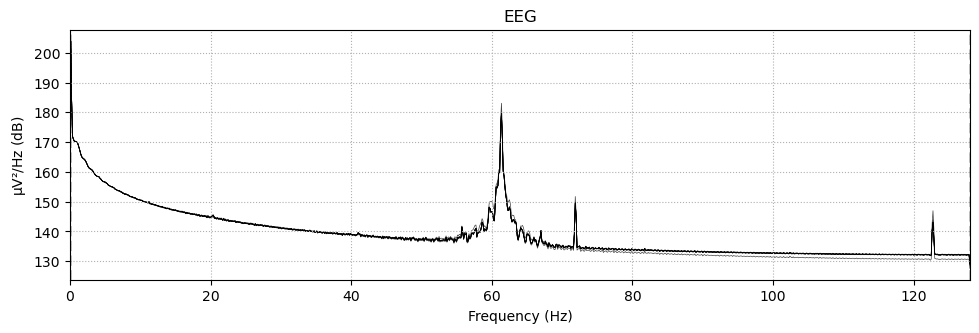

In [7]:
# load data from .csv file name 'combined_recording_##########.csv' from data/recordings folder, use columns 0-7, 17, 19
data = pd.read_csv('data/recordings/combined_recording_1701570005.csv', usecols=[0,1,2,3,4,5,6,7,18,20])

# channel info (check electode placement/name and columsn in data)
ch_names = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'Type', 'TimeStamp']
sfreq = 256  # sampling frequency in Hz

# channel types (8 channels of EEG data and 2 for image type and stimulus time)
ch_types = ['eeg'] * 8 + ['misc'] * 2

# create info object and raw data object
info = mne.create_info(ch_names, sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data.T, info)
raw.plot_psd()

In [8]:
# raw.set_montage('standard_1020')

raw.apply_function(lambda x: x * 1e-6)

raw.filter(2,30, method='fft')

<RawArray | 10 x 35987 (140.6 s), ~2.8 MB, data loaded>

In [9]:
# isolate the image stimulus
events = mne.find_events(raw, stim_channel='Type')

print(events)

# isolate image stimulus events
i = 0
for e in events:
    events = np.insert(events, i, [e[0]-200, 2, 0], axis=0)
    i+=2

for e in events:
    if e[2] == 1:
        e[1] = 1
        e[2] = 0

events = mne.find_events(raw, stim_channel='Type')

# isolate on task events
i = 0
for e in events:
    events = np.insert(events, i, [e[0]-200, 0, 2], axis=0)
    i+=2

# # set event_id equal to channel 9 (Type) value 1 or 2
event_id = {'real': 1, 'ai': 2}


[[  504     0     2]
 [ 1260     0     2]
 [ 2015     0     1]
 [ 2770     0     2]
 [ 3525     0     2]
 [ 4279     0     2]
 [ 5035     0     1]
 [ 5790     0     2]
 [ 6544     0     1]
 [ 7298     0     1]
 [ 8053     0     1]
 [ 8804     0     2]
 [ 9561     0     1]
 [10317     0     2]
 [11072     0     2]
 [11827     0     1]
 [12586     0     2]
 [13337     0     1]
 [14094     0     2]
 [14849     0     2]
 [15603     0     1]
 [16357     0     1]
 [17115     0     1]
 [17871     0     2]
 [18626     0     2]
 [19378     0     1]
 [20132     0     1]
 [20887     0     1]
 [21641     0     2]
 [22396     0     2]
 [23155     0     2]
 [23907     0     1]
 [24657     0     2]
 [25414     0     1]
 [26169     0     1]
 [26924     0     1]
 [27678     0     2]
 [28433     0     1]
 [29187     0     1]
 [29941     0     2]
 [30701     0     2]
 [31456     0     2]
 [32211     0     2]
 [32965     0     1]
 [33720     0     1]
 [34473     0     1]
 [35228     0     2]]


In [10]:
# # print unique values in last colum of events and event_id
# print("Unique values in events:", np.unique(events[:, -1]))
# print("Event ID dictionary:", event_id)

# event_values = raw._data[ch_names.index('TimeStamp')]
# print("Event values in the raw data:", np.unique(event_values))

slice = events[]  # replace 'condition' with your slicing condition
if slice.size > 0:
    print("The slice is not empty.")
else:
    print("The slice is empty.")

SyntaxError: invalid syntax (3121795723.py, line 8)

In [11]:
print(raw._data.shape)
print(raw.info.keys())
raw.info

(10, 35987)
dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])


<Info | 7 non-empty values
 bads: []
 ch_names: CH1, CH2, CH3, CH4, CH5, CH6, CH7, CH8, Type, TimeStamp
 chs: 8 EEG, 2 misc
 custom_ref_applied: False
 highpass: 2.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 10
 projs: []
 sfreq: 256.0 Hz
>

/Users/brynnharrisshanks/mambaforge/envs/ncil/lib/python3.11/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


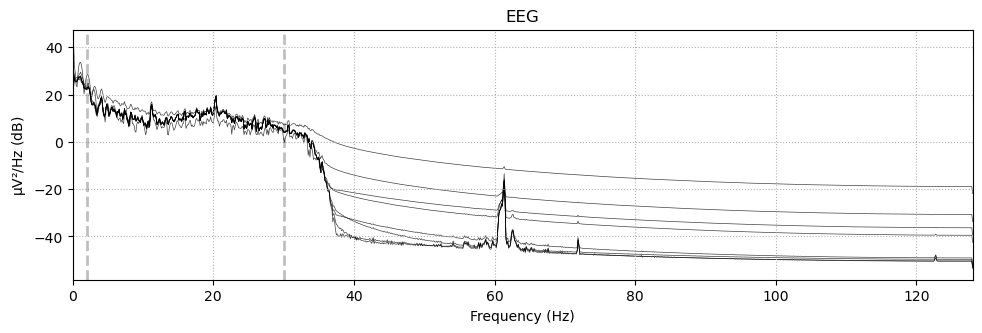

In [12]:
raw.plot(start=15, duration=10, n_channels=8, scalings='auto')
raw.compute_psd().plot()

In [13]:
# make epochs
epochs = mne.Epochs(raw, events, tmin=0, tmax=2, baseline=None, proj=False, detrend=1, preload=True, event_repeated='merge',
                    reject = dict(eeg=1e-3))

print(epochs)

labels = epochs.events[:, -1]

psd = epochs.compute_psd(method='multitaper', tmin=0, tmax=2, fmin=2, fmax=30, picks='eeg')




<Epochs |  94 events (all good), 0 – 2 s, baseline off, ~3.7 MB, data loaded,
 '1': 23
 '2': 71>


In [16]:
psds = []


psd = 10 * np.log10(psd)
reshaped_psd = psd.reshape(len(psd), len(psd[0]) * len(psd[0][0])) # convert the data into a two dimensional array
psds.append(reshaped_psd)


/var/folders/93/slc_n35j5xz13d4pmpgtk1lc0000gn/T/ipykernel_76959/4160623596.py:4: RuntimeWarning: invalid value encountered in log10
  psd = 10 * np.log10(psd)


In [23]:
clf = RidgeClassifier()
sam = np.asarray(psds)
lab = np.asarray(labels)
preds = np.empty(len(labels))

print(labels)

# #sam_sparse = coo_matrix(sam)
# #sam, sam_sparse, lab = shuffle(sam, sam_sparse, lab, random_state=42)

# sam_train, sam_test, lab_train, lab_test = train_test_split(sam[0], lab[0], test_size=0.25, random_state=42)
# clf.fit(sam_train, lab_train)
# savefile = '../data/classifier_save.sav'
# pickle.dump(clf, open(savefile, 'wb'))
# preds = clf.predict(sam_test)

# report = classification_report(lab_test, preds)
# acc = accuracy_score(lab_test, preds)

# print("The accuracy for this participant: " + str(acc * 100) + "% \n")

[2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2
 2 2 2 2 1 2 1 2 1 2 2 2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 1 2 2
 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 2]
